In [15]:
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [16]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

Text(0.5, 1.0, '(Label: 0)')

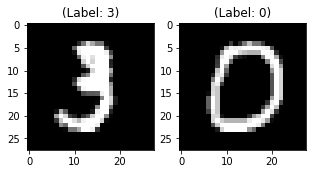

In [17]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(curr_lbl) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(curr_lbl) + ")")

In [18]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [19]:
# Scale the data so that all values are in the [0, 1] interval.
train_data = train_data / 255
test_data = test_data / 255

In [20]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [21]:
batch_size = 64
epochs = 200
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [22]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [23]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [24]:
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 64)       

In [25]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/200
750/750 [==============================] - 8s 10ms/step - loss: 0.0184 - val_loss: 0.0073
Epoch 2/200
750/750 [==============================] - 7s 10ms/step - loss: 0.0052 - val_loss: 0.0060
Epoch 3/200
750/750 [==============================] - 7s 9ms/step - loss: 0.0037 - val_loss: 0.0071
Epoch 4/200
750/750 [==============================] - 7s 9ms/step - loss: 0.0030 - val_loss: 0.0068
Epoch 5/200
750/750 [==============================] - 7s 9ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 6/200
750/750 [==============================] - 7s 9ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 7/200
750/750 [==============================] - 7s 10ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 8/200
750/750 [==============================] - 7s 9ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/200
750/750 [==============================] - 7s 9ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/200
750/750 [==============================] - 7s 9ms/step - loss: 0.0016 - val

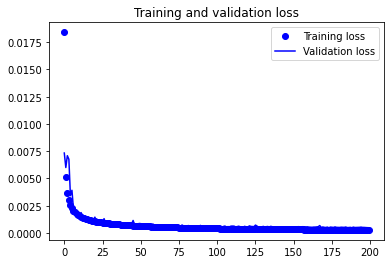

In [26]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
autoencoder.save_weights('autoencoder.h5')

# Segment the mnist images

In [28]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 5
After conversion to one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [29]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)

In [30]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [31]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [32]:
encode = encoder(input_img)
full_model = Model(input_img, fc(encode))

**Ensure that the autoencoder weights and full_model weights are the same.**

In [33]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [34]:
autoencoder.get_weights()[0][1]

array([[[-0.35850146, -0.3628897 ,  0.16320843, -0.02042229,
         -0.58496195, -0.544155  ,  0.38917303, -0.8539123 ,
          0.00600353,  0.3952878 ,  0.24810702,  0.00495473,
         -0.04551886,  0.27502927, -0.02461718, -0.3591425 ,
         -0.09031041, -0.28026372,  0.4447739 , -0.8681317 ,
         -0.08619917, -0.5650598 ,  0.11265071,  0.45872423,
         -0.09013296,  0.18074892, -0.7344903 ,  0.54246145,
          0.52303606,  0.16706619, -0.41626394,  0.310458  ]],

       [[-0.35082301, -0.05836569,  0.67418426, -0.16739982,
         -0.9620832 ,  0.02024651, -1.1448654 , -1.1831212 ,
         -0.21178341,  0.407842  , -0.24093373,  0.12326954,
         -0.06206692,  0.13861604, -0.05252824,  0.45764706,
          0.12397981, -0.19465357,  0.31997004,  0.35627094,
         -0.03023756, -0.560177  ,  0.05996694, -0.81095374,
          0.5384732 ,  0.5109031 , -0.10160064, -0.5953662 ,
         -0.4465535 ,  0.31799713, -0.14769666, -0.02368569]],

       [[-0.109859

In [35]:
full_model.get_weights()[0][1]

array([[[-0.35850146, -0.3628897 ,  0.16320843, -0.02042229,
         -0.58496195, -0.544155  ,  0.38917303, -0.8539123 ,
          0.00600353,  0.3952878 ,  0.24810702,  0.00495473,
         -0.04551886,  0.27502927, -0.02461718, -0.3591425 ,
         -0.09031041, -0.28026372,  0.4447739 , -0.8681317 ,
         -0.08619917, -0.5650598 ,  0.11265071,  0.45872423,
         -0.09013296,  0.18074892, -0.7344903 ,  0.54246145,
          0.52303606,  0.16706619, -0.41626394,  0.310458  ]],

       [[-0.35082301, -0.05836569,  0.67418426, -0.16739982,
         -0.9620832 ,  0.02024651, -1.1448654 , -1.1831212 ,
         -0.21178341,  0.407842  , -0.24093373,  0.12326954,
         -0.06206692,  0.13861604, -0.05252824,  0.45764706,
          0.12397981, -0.19465357,  0.31997004,  0.35627094,
         -0.03023756, -0.560177  ,  0.05996694, -0.81095374,
          0.5384732 ,  0.5109031 , -0.10160064, -0.5953662 ,
         -0.4465535 ,  0.31799713, -0.14769666, -0.02368569]],

       [[-0.109859

**The weights are the same.**

In [36]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [37]:
full_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [39]:
full_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_28 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 64)       

# Train the Model

In [40]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/100
750/750 [==============================] - 3s 4ms/step - loss: 0.2065 - accuracy: 0.9414 - val_loss: 0.1496 - val_accuracy: 0.9592
Epoch 2/100
750/750 [==============================] - 3s 4ms/step - loss: 0.0648 - accuracy: 0.9790 - val_loss: 0.1130 - val_accuracy: 0.9700
Epoch 3/100
750/750 [==============================] - 3s 4ms/step - loss: 0.0369 - accuracy: 0.9883 - val_loss: 0.1721 - val_accuracy: 0.9614
Epoch 4/100
750/750 [==============================] - 3s 4ms/step - loss: 0.0322 - accuracy: 0.9891 - val_loss: 0.1474 - val_accuracy: 0.9682
Epoch 5/100
750/750 [==============================] - 3s 4ms/step - loss: 0.0281 - accuracy: 0.9914 - val_loss: 0.1375 - val_accuracy: 0.9710
Epoch 6/100
750/750 [==============================] - 3s 4ms/step - loss: 0.0265 - accuracy: 0.9915 - val_loss: 0.1392 - val_accuracy: 0.9733
Epoch 7/100
750/750 [==============================] - 3s 4ms/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 0.1422 - val_accuracy: 0.9738

In [41]:
full_model.save_weights('autoencoder_classification.h5')

In [42]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [44]:
full_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [45]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/100
750/750 [==============================] - 5s 7ms/step - loss: 0.1509 - accuracy: 0.9918 - val_loss: 0.9599 - val_accuracy: 0.9748
Epoch 2/100
750/750 [==============================] - 5s 7ms/step - loss: 0.0951 - accuracy: 0.9941 - val_loss: 0.6061 - val_accuracy: 0.9766
Epoch 3/100
750/750 [==============================] - 5s 7ms/step - loss: 0.0710 - accuracy: 0.9948 - val_loss: 0.6076 - val_accuracy: 0.9808
Epoch 4/100
750/750 [==============================] - 5s 7ms/step - loss: 0.0558 - accuracy: 0.9956 - val_loss: 0.6218 - val_accuracy: 0.9785
Epoch 5/100
750/750 [==============================] - 5s 7ms/step - loss: 0.0696 - accuracy: 0.9951 - val_loss: 0.4854 - val_accuracy: 0.9797
Epoch 6/100
750/750 [==============================] - 5s 7ms/step - loss: 0.0522 - accuracy: 0.9952 - val_loss: 0.5320 - val_accuracy: 0.9791
Epoch 7/100
750/750 [==============================] - 5s 7ms/step - loss: 0.0481 - accuracy: 0.9959 - val_loss: 0.5590 - val_accuracy: 0.9732

In [46]:
full_model.save_weights('classification_complete.h5')

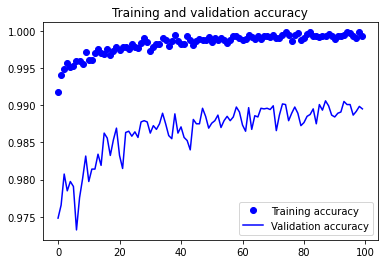

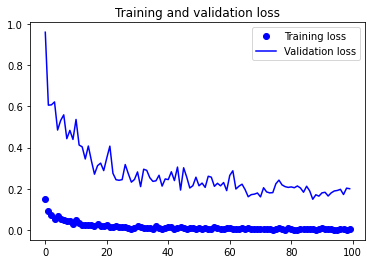

In [47]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Model Evaluation on the Test Set

In [48]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)

In [49]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.17229920625686646
Test accuracy: 0.9894000291824341


# Predict Labels

In [50]:
predicted_classes = full_model.predict(test_data)

In [51]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [52]:
predicted_classes.shape, test_labels.shape

((10000,), (10000,))

Found 9893 correct labels


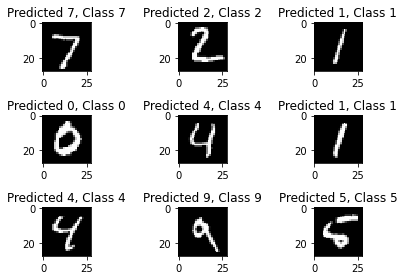

In [53]:
correct = np.where(predicted_classes==test_labels)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Found 107 incorrect labels


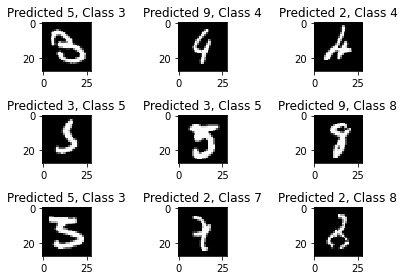

In [54]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

# Classification Report

In [55]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99       980
     Class 1       0.99      1.00      1.00      1135
     Class 2       0.99      0.99      0.99      1032
     Class 3       0.99      0.99      0.99      1010
     Class 4       0.99      0.99      0.99       982
     Class 5       0.98      0.99      0.98       892
     Class 6       0.99      0.99      0.99       958
     Class 7       0.99      0.99      0.99      1028
     Class 8       1.00      0.99      0.99       974
     Class 9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

